In [634]:
import pandas as pd 
import numpy as np 
import os 
import requests
import joblib
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats 
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [666]:
# Specify the folder where the CSV files are located
directory = '/Users/blairjdaniel/lighthouse/lighthouse/NHL/NHL_points_projection/files/skaters'

# Use glob to find all CSV files in the dir
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Initialize an empty dataframe
dataframes = []

# Loop through the CSV file and read it into a DF
for csv_file in csv_files:
    goalies = pd.read_csv(csv_file)
    dataframes.append(goalies)

    # # Check if the file is goalies_2010.csv and print a message
    # if 'goalies_2010.csv' in csv_file:
    #     print(f"goalies_2010.csv file loaded successfully.")
    #     print(goalies.head())  # Display the first few rows of the DataFrame


# Concatenate all DF into one master DataFrame
skaters_df = pd.concat(dataframes, ignore_index=True)
len(skaters_df)

76420

In [636]:
skaters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76420 entries, 0 to 76419
Columns: 154 entries, playerId to fenwickAgainstAfterShifts
dtypes: float64(147), int64(3), object(4)
memory usage: 89.8+ MB


In [637]:
skaters_df.describe()

,playerId,season,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,offIce_xGoalsPercentage,onIce_corsiPercentage,offIce_corsiPercentage,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
count,7.642000e+04,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,...,76420.000000,76420.00000,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,76420.000000,76420.00000
mean,8.474573e+06,2016.094936,47.217024,18704.155509,402.495747,17.733023,0.437301,0.470338,0.445056,0.470045,...,36.077281,36.47520,739.951583,747.031837,0.350977,0.175855,7.826132,4.168215,6.087242,3.32833
std,4.854299e+03,4.902584,28.033181,27355.282550,580.507464,21.281237,0.293792,0.266078,0.281351,0.257651,...,49.682677,49.76639,1047.181368,1049.865409,0.995827,0.450861,21.702521,10.244024,16.865262,8.20021
min,8.445550e+06,2008.000000,1.000000,0.000000,0.000000,-12.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,8.471346e+06,2012.000000,20.000000,500.000000,16.000000,1.060000,0.160000,0.330000,0.200000,0.350000,...,2.140000,1.94000,34.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,8.475208e+06,2016.000000,53.000000,4202.500000,89.000000,9.320000,0.470000,0.490000,0.480000,0.490000,...,9.890000,10.35000,127.000000,131.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,8.477930e+06,2020.000000,73.000000,29184.750000,663.000000,28.090000,0.580000,0.570000,0.580000,0.550000,...,63.250000,64.27250,1411.000000,1427.000000,0.110000,0.050000,2.000000,2.000000,2.000000,1.00000
max,8.485105e+06,2024.000000,85.000000,144666.000000,2730.000000,154.730000,1.000000,1.000000,1.000000,1.000000,...,271.990000,246.92000,4797.000000,4499.000000,11.640000,5.670000,232.000000,100.000000,174.000000,78.00000


In [638]:
skaters_df.columns.to_list()

['playerId',
 'season',
 'name',
 'team',
 'position',
 'situation',
 'games_played',
 'icetime',
 'shifts',
 'gameScore',
 'onIce_xGoalsPercentage',
 'offIce_xGoalsPercentage',
 'onIce_corsiPercentage',
 'offIce_corsiPercentage',
 'onIce_fenwickPercentage',
 'offIce_fenwickPercentage',
 'iceTimeRank',
 'I_F_xOnGoal',
 'I_F_xGoals',
 'I_F_xRebounds',
 'I_F_xFreeze',
 'I_F_xPlayStopped',
 'I_F_xPlayContinuedInZone',
 'I_F_xPlayContinuedOutsideZone',
 'I_F_flurryAdjustedxGoals',
 'I_F_scoreVenueAdjustedxGoals',
 'I_F_flurryScoreVenueAdjustedxGoals',
 'I_F_primaryAssists',
 'I_F_secondaryAssists',
 'I_F_shotsOnGoal',
 'I_F_missedShots',
 'I_F_blockedShotAttempts',
 'I_F_shotAttempts',
 'I_F_points',
 'I_F_goals',
 'I_F_rebounds',
 'I_F_reboundGoals',
 'I_F_freeze',
 'I_F_playStopped',
 'I_F_playContinuedInZone',
 'I_F_playContinuedOutsideZone',
 'I_F_savedShotsOnGoal',
 'I_F_savedUnblockedShotAttempts',
 'penalties',
 'I_F_penalityMinutes',
 'I_F_faceOffsWon',
 'I_F_hits',
 'I_F_takeaways

In [667]:
# Initialize an empty list to store DataFrames
pivoted_dfs = []
cols_to_drop = [
    'team',
    'gameScore',
    'onIce_xGoalsPercentage',
    'offIce_xGoalsPercentage',
    'offIce_corsiPercentage',
    'offIce_fenwickPercentage',
    'iceTimeRank',
    'I_F_xOnGoal',
    'I_F_xGoals',
    'I_F_xRebounds',
    'I_F_xFreeze',
    'I_F_xPlayStopped',
    'I_F_xPlayContinuedInZone',
    'I_F_xPlayContinuedOutsideZone',
    'I_F_flurryAdjustedxGoals',
    'I_F_scoreVenueAdjustedxGoals',
    'I_F_flurryScoreVenueAdjustedxGoals',
    'I_F_freeze',
    'I_F_playStopped',
    'I_F_playContinuedInZone',
    'I_F_playContinuedOutsideZone',
    'I_F_savedShotsOnGoal',
    'I_F_savedUnblockedShotAttempts',
    'penalties',
    'I_F_lowDangerxGoals',
    'I_F_highDangerxGoals',
    'I_F_mediumDangerxGoals',
    'I_F_scoreAdjustedShotsAttempts',
    'I_F_unblockedShotAttempts',
    'I_F_scoreAdjustedUnblockedShotAttempts',
    'I_F_dZoneGiveaways',
    'I_F_xGoalsFromxReboundsOfShots',
    'I_F_xGoalsFromActualReboundsOfShots',
    'I_F_xGoals_with_earned_rebounds',
    'I_F_xGoals_with_earned_rebounds_scoreAdjusted',
    'I_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted',
    'I_F_neutralZoneShiftStarts',
    'I_F_flyShiftStarts',
    'I_F_oZoneShiftEnds',
    'I_F_dZoneShiftEnds',
    'I_F_neutralZoneShiftEnds',
    'I_F_flyShiftEnds',
    'I_F_faceOffsWon',
    'timeOnBench',
    'penalityMinutes',
    'penalityMinutesDrawn',
    'OnIce_F_xOnGoal',
    'OnIce_F_xGoals',
    'OnIce_F_flurryAdjustedxGoals',
    'OnIce_F_scoreVenueAdjustedxGoals',
    'OnIce_F_flurryScoreVenueAdjustedxGoals',
    'OnIce_F_shotsOnGoal',
    'OnIce_F_missedShots',
    'OnIce_F_blockedShotAttempts',
    'OnIce_F_shotAttempts',
    'OnIce_F_goals',
    'OnIce_F_rebounds',
    'OnIce_F_reboundGoals',
    'OnIce_F_lowDangerShots',
    'OnIce_F_mediumDangerShots',
    'OnIce_F_highDangerShots',
    'OnIce_F_lowDangerxGoals',
    'OnIce_F_mediumDangerxGoals',
    'OnIce_F_highDangerxGoals',
    'OnIce_F_lowDangerGoals',
    'OnIce_F_mediumDangerGoals',
    'OnIce_F_highDangerGoals',
    'OnIce_F_scoreAdjustedShotsAttempts',
    'OnIce_F_unblockedShotAttempts',
    'OnIce_F_scoreAdjustedUnblockedShotAttempts',
    'OnIce_F_xGoalsFromxReboundsOfShots',
    'OnIce_F_xGoalsFromActualReboundsOfShots',
    'OnIce_F_reboundxGoals',
    'OnIce_F_xGoals_with_earned_rebounds',
    'OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted',
    'OnIce_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted',
    'OnIce_A_xOnGoal',
    'OnIce_A_xGoals',
    'OnIce_A_flurryAdjustedxGoals',
    'OnIce_A_scoreVenueAdjustedxGoals',
    'OnIce_A_flurryScoreVenueAdjustedxGoals',
    'OnIce_A_shotsOnGoal',
    'OnIce_A_missedShots',
    'OnIce_A_blockedShotAttempts',
    'OnIce_A_shotAttempts',
    'OnIce_A_goals',
    'OnIce_A_rebounds',
    'OnIce_A_reboundGoals',
    'OnIce_A_lowDangerShots',
    'OnIce_A_mediumDangerShots',
    'OnIce_A_highDangerShots',
    'OnIce_A_lowDangerxGoals',
    'OnIce_A_mediumDangerxGoals',
    'OnIce_A_highDangerxGoals',
    'OnIce_A_lowDangerGoals',
    'OnIce_A_mediumDangerGoals',
    'OnIce_A_highDangerGoals',
    'OnIce_A_scoreAdjustedShotsAttempts',
    'OnIce_A_unblockedShotAttempts',
    'OnIce_A_scoreAdjustedUnblockedShotAttempts',
    'OnIce_A_xGoalsFromxReboundsOfShots',
    'OnIce_A_xGoalsFromActualReboundsOfShots',
    'OnIce_A_reboundxGoals',
    'OnIce_A_xGoals_with_earned_rebounds',
    'OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted',
    'OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted',
    'OffIce_F_xGoals',
    'OffIce_A_xGoals',
    'OffIce_F_shotAttempts',
    'OffIce_A_shotAttempts',
    'xGoalsForAfterShifts',
    'xGoalsAgainstAfterShifts',
    'corsiForAfterShifts',
    'corsiAgainstAfterShifts',
    'fenwickForAfterShifts',
    'fenwickAgainstAfterShifts',
    'OnIce_A_reboundxGoals',
    'OnIce_A_reboundxGoals',
]

# List of situations
situations = ['all']

# Loop through each situation and pivot the DataFrame
for situation in situations:
    # Filter the DataFrame for the specific situation
    situation_df = skaters_df[skaters_df['situation'] == situation]
    
    # Drop specific columns
    situation_df = situation_df.drop(columns=cols_to_drop)

    # Pivot the DataFrame
    pivoted_df = situation_df.pivot_table(index=['name', 'season'], aggfunc='first')
    
    # Flatten the columns
    pivoted_df.columns = [f'{col}' for col in pivoted_df.columns]
    
    # Reset the index
    pivoted_df = pivoted_df.reset_index()
    
    # Append the pivoted DataFrame to the list
    pivoted_dfs.append(pivoted_df)

# Merge all pivoted DataFrames into one master DataFrame
df_all = pivoted_dfs[0]
for pivoted_df in pivoted_dfs[1:]:
    df_all = df_all.merge(pivoted_df, on=['name', 'season'], how='outer')


In [668]:
# add primary and secondary assist cols to make assist col then drop cols
df_all['assists'] = df_all['I_F_primaryAssists'] + df_all['I_F_secondaryAssists']
df_all = df_all.drop(columns=['I_F_primaryAssists', 'I_F_secondaryAssists'])

In [669]:
# Change the values in the 'position' column based on the position
df_all['position'] = np.where(df_all['position'].str.contains('L|C|R'), 'F', df_all['position'])
df_all['position'] = np.where(df_all['position'].str.contains('D'), 'D', df_all['position'])

# Display the updated 'position' column
print(df_all['position'])

0        F
1        F
2        F
3        F
4        F
        ..
15271    F
15272    F
15273    F
15274    F
15275    F
Name: position, Length: 15276, dtype: object


In [670]:
# Use encoding to give the positions a numeric value
le = LabelEncoder()
df_all['position'] = df_all['position'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x) 

# Fit the encoder and transform the 'position' column
df_all['PositionEn_encoded'] = le.fit_transform(df_all['position'])
#df_all = df_all.drop(columns=['position'])

In [643]:
df_all.columns.to_list()

['name',
 'season',
 'I_F_blockedShotAttempts',
 'I_F_dZoneShiftStarts',
 'I_F_giveaways',
 'I_F_goals',
 'I_F_highDangerGoals',
 'I_F_highDangerShots',
 'I_F_hits',
 'I_F_lowDangerGoals',
 'I_F_lowDangerShots',
 'I_F_mediumDangerGoals',
 'I_F_mediumDangerShots',
 'I_F_missedShots',
 'I_F_oZoneShiftStarts',
 'I_F_penalityMinutes',
 'I_F_points',
 'I_F_reboundGoals',
 'I_F_rebounds',
 'I_F_reboundxGoals',
 'I_F_shifts',
 'I_F_shotAttempts',
 'I_F_shotsOnGoal',
 'I_F_takeaways',
 'faceoffsLost',
 'faceoffsWon',
 'games_played',
 'icetime',
 'onIce_corsiPercentage',
 'onIce_fenwickPercentage',
 'penaltiesDrawn',
 'playerId',
 'position',
 'shifts',
 'shotsBlockedByPlayer',
 'situation',
 'assists',
 'PositionEn_encoded']

In [671]:
# Group the DataFrame by 'name' and 'season'
df_all_grouped = df_all.groupby(by=['name']).agg({
    'season': 'first',  # Keep the first occurrence of 'season'
    'I_F_dZoneShiftStarts': 'sum',  # Sum the 'I_F_dZoneShiftStarts' values
    'I_F_giveaways': 'sum',  # Sum the 'I_F_giveaways' values
    'I_F_goals': 'sum',  # Sum the 'I_F_goals' values
    'I_F_highDangerGoals': 'sum',  # Sum the 'I_F_highDangerGoals' values
    'I_F_highDangerShots': 'sum',  # Sum the 'I_F_highDangerShots' values
    'I_F_hits': 'sum',  # Sum the 'I_F_hits' values
    'I_F_lowDangerGoals': 'sum',  # Sum the 'I_F_lowDangerGoals' values
    'I_F_lowDangerShots': 'sum',  # Sum the 'I_F_lowDangerShots' values
    'I_F_mediumDangerGoals': 'sum',  # Sum the 'I_F_mediumDangerGoals' values
    'I_F_mediumDangerShots': 'sum',  # Sum the 'I_F_mediumDangerShots' values
    'I_F_missedShots': 'sum',  # Sum the 'I_F_missedShots' values
    'I_F_oZoneShiftStarts': 'sum',  # Sum the 'I_F_oZoneShiftStarts' values
    'I_F_penalityMinutes': 'sum',  # Sum the 'I_F_penalityMinutes' values
    'I_F_points': 'sum',  # Sum the 'I_F_points' values
    'I_F_reboundGoals': 'sum',  # Sum the 'I_F_reboundGoals' values
    'I_F_rebounds': 'sum',  # Sum the 'I_F_rebounds' values
    'I_F_shifts': 'sum',  # Sum the 'I_F_shifts' values
    'I_F_shotAttempts': 'sum',  # Sum the 'I_F_shotAttempts' values
    'I_F_shotsOnGoal': 'sum',  # Sum the 'I_F_shotsOnGoal' values
    'I_F_takeaways': 'sum',  # Sum the 'I_F_takeaways' values
    'faceoffsLost': 'sum',  # Sum the 'faceoffsLost' values
    'faceoffsWon': 'sum',  # Sum the 'faceoffsWon' values
    'games_played': 'sum',  # Sum the 'games_played' values
    'icetime': 'sum',  # Sum the 'icetime' values
    'onIce_corsiPercentage': 'sum',  # Sum the 'onIce_corsiPercentage' values
    'onIce_fenwickPercentage': 'sum',  # Sum the 'onIce_fenwickPercentage' values
    'penaltiesDrawn': 'sum',  # Sum the 'penaltiesDrawn' values
    'playerId': 'first',  # Keep the first occurrence of 'playerId'
    'position': 'first',
    'shifts': 'sum',  # Sum the 'shifts' values
    'shotsBlockedByPlayer': 'sum',  # Sum the 'shotsBlockedByPlayer' values
    'situation': 'first',  # Keep the first occurrence of 'situation'
    'assists': 'sum',  # Sum the 'assists' values
    'PositionEn_encoded': 'first'  # Keep the first occurrence of 'PositionEn_encoded'
}).reset_index()

# Convert the grouped DataFrame to a regular DataFrame
df_all_grouped

,name,season,I_F_dZoneShiftStarts,I_F_giveaways,I_F_goals,I_F_highDangerGoals,I_F_highDangerShots,I_F_hits,I_F_lowDangerGoals,I_F_lowDangerShots,...,onIce_corsiPercentage,onIce_fenwickPercentage,penaltiesDrawn,playerId,position,shifts,shotsBlockedByPlayer,situation,assists,PositionEn_encoded
0,A.J. Greer,2016,291.0,74.0,19.0,9.0,37.0,459.0,8.0,202.0,...,3.63,3.72,66.0,8478421,F,3078.0,87.0,all,29.0,1
1,Aaron Downey,2008,0.0,2.0,1.0,0.0,0.0,11.0,0.0,1.0,...,0.45,0.48,2.0,8465992,F,34.0,1.0,all,1.0,1
2,Aaron Ekblad,2014,2907.0,678.0,117.0,28.0,73.0,834.0,65.0,2185.0,...,6.00,5.95,130.0,8477932,D,19823.0,787.0,all,259.0,0
3,Aaron Gagnon,2009,57.0,2.0,3.0,0.0,3.0,24.0,1.0,35.0,...,2.00,1.98,1.0,8471451,F,481.0,14.0,all,2.0,1
4,Aaron Johnson,2008,317.0,62.0,10.0,4.0,7.0,229.0,6.0,191.0,...,1.98,1.99,24.0,8469534,D,3018.0,156.0,all,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,Zack Stortini,2008,196.0,27.0,10.0,3.0,14.0,286.0,3.0,84.0,...,1.60,1.51,84.0,8470687,F,1872.0,48.0,all,18.0,1
2939,Zbynek Michalek,2008,2549.0,207.0,24.0,3.0,9.0,521.0,16.0,890.0,...,3.77,3.81,77.0,8469760,D,14231.0,1257.0,all,83.0,0
2940,Zdeno Chara,2008,4476.0,796.0,124.0,34.0,82.0,1802.0,69.0,2736.0,...,6.93,6.91,228.0,8465009,D,26691.0,1417.0,all,286.0,0
2941,Zemgus Girgensons,2013,2482.0,141.0,91.0,26.0,101.0,1376.0,22.0,947.0,...,4.77,4.76,168.0,8476878,F,14461.0,405.0,all,103.0,1


In [672]:
# Create a dictionary for renaming columns
rename_dict = {
    'playerId': 'player_id',
    'I_F_dZoneShiftStarts': 'd_zone_shift_starts',
    'I_F_giveaways': 'giveaways',
    'I_F_goals': 'goals',
    'I_F_highDangerGoals': 'high_danger_goals',
    'I_F_highDangerShots': 'high_danger_shots',
    'I_F_hits': 'hits',
    'I_F_lowDangerGoals': 'low_danger_goals',
    'I_F_lowDangerShots': 'low_danger_shots',
    'I_F_mediumDangerGoals': 'medium_danger_goals',
    'I_F_mediumDangerShots': 'medium_danger_shots',
    'I_F_missedShots': 'missed_shots',
    'I_F_oZoneShiftStarts': 'o_zone_shift_starts',
    'I_F_penalityMinutes': 'penalty_minutes',
    'I_F_points': 'points',
    'I_F_reboundGoals': 'rebound_goals',
    'I_F_rebounds': 'rebounds',
    'I_F_shifts': 'shifts',
    'I_F_shotAttempts': 'shot_attempts',
    'I_F_shotsOnGoal': 'shots_on_goal',
    'I_F_takeaways': 'takeaways',
    'faceoffsLost': 'faceoffs_lost',
    'faceoffsWon': 'faceoffs_won',
    'games_played': 'games_played',
    'icetime': 'icetime',
    'onIce_corsiPercentage': 'on_ice_corsi_percentage',
    'onIce_fenwickPercentage': 'on_ice_fenwick_percentage',
    'penaltiesDrawn': 'penalties_drawn',
    'shotsBlockedByPlayer': 'shots_blocked_by_player',
    'PositionEn_encoded': 'position_encoded'
}

# Rename the columns
df_all_grouped = df_all_grouped.rename(columns=rename_dict)

# Display the resulting DataFrame
skater_df = df_all_grouped.drop(columns=['situation','player_id', 'season'])
skater_df

,name,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,low_danger_shots,medium_danger_goals,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,position,shifts,shots_blocked_by_player,assists,position_encoded
0,A.J. Greer,291.0,74.0,19.0,9.0,37.0,459.0,8.0,202.0,2.0,...,234,125080.0,3.63,3.72,66.0,F,3078.0,87.0,29.0,1
1,Aaron Downey,0.0,2.0,1.0,0.0,0.0,11.0,0.0,1.0,1.0,...,4,1250.0,0.45,0.48,2.0,F,34.0,1.0,1.0,1
2,Aaron Ekblad,2907.0,678.0,117.0,28.0,73.0,834.0,65.0,2185.0,24.0,...,729,1000637.0,6.00,5.95,130.0,D,19823.0,787.0,259.0,0
3,Aaron Gagnon,57.0,2.0,3.0,0.0,3.0,24.0,1.0,35.0,2.0,...,38,19110.0,2.00,1.98,1.0,F,481.0,14.0,2.0,1
4,Aaron Johnson,317.0,62.0,10.0,4.0,7.0,229.0,6.0,191.0,0.0,...,146,136534.0,1.98,1.99,24.0,D,3018.0,156.0,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,Zack Stortini,196.0,27.0,10.0,3.0,14.0,286.0,3.0,84.0,4.0,...,162,79572.0,1.60,1.51,84.0,F,1872.0,48.0,18.0,1
2939,Zbynek Michalek,2549.0,207.0,24.0,3.0,9.0,521.0,16.0,890.0,5.0,...,521,660370.0,3.77,3.81,77.0,D,14231.0,1257.0,83.0,0
2940,Zdeno Chara,4476.0,796.0,124.0,34.0,82.0,1802.0,69.0,2736.0,21.0,...,992,1387884.0,6.93,6.91,228.0,D,26691.0,1417.0,286.0,0
2941,Zemgus Girgensons,2482.0,141.0,91.0,26.0,101.0,1376.0,22.0,947.0,43.0,...,755,635188.0,4.77,4.76,168.0,F,14461.0,405.0,103.0,1


In [646]:
skaters_all = pd.read_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/NHL_points_projection/files/master_copies/player_team_2025.csv')

In [673]:
# Filter the DataFrame to include only rows where position_encoded is 0
skaters_all = skaters_all[skaters_all['position_encoded'] == 1]
#skaters_all = skaters_all.drop(columns=['Unnamed: 0'])
skaters_all.head()

,name,team,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,low_danger_shots,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,position,shots_blocked_by_player,assists,position_encoded,salary
0,A.J. Greer,Florida Panthers,0.000184,0.000076,0.001051,0.000108,0.000757,0.010002,0.000058,0.001304,...,68,0.002341,0.000001,0.000001,0.000054,F,0.001189,0.001927,1,950000.0
2,Aatu Raty,Vancouver Canucks,0.000567,0.000091,0.003673,0.000000,0.000000,0.030045,0.000204,0.002857,...,21,0.007544,0.000011,0.000010,0.000045,F,0.002268,0.003673,1,950000.0
4,Adam Edstrom,New York Rangers,0.000458,0.000073,0.001557,0.000096,0.001057,0.009035,0.000035,0.000830,...,51,0.003031,0.000002,0.000002,0.000038,F,0.003268,0.001246,1,950000.0
5,Adam Fantilli,Columbus Blue Jackets,0.000176,0.000169,0.003789,0.000334,0.000557,0.005179,0.000060,0.003468,...,67,0.004424,0.000001,0.000001,0.000038,F,0.002729,0.003789,1,950000.0
7,Adam Gaudette,Ottawa Senators,0.000130,0.000088,0.003067,0.000355,0.000828,0.003373,0.000064,0.001768,...,65,0.002702,0.000001,0.000001,0.000005,F,0.001538,0.001342,1,4000000.0


In [648]:
# Check for NaN values in the DataFrame
nan_summary = skaters_all.isna().sum()

# Display columns with NaN values
print("Columns with NaN values:")
print(nan_summary[nan_summary > 0])

Columns with NaN values:
Series([], dtype: int64)


In [649]:
skaters_all['icetime'] = skaters_all['icetime'] / 60

In [650]:
skaters_all['icetime'] = skaters_all['icetime'] / skaters_all['games_played']
skaters_all.head()

,Unnamed: 0,name,team,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,position,shots_blocked_by_player,assists,position_encoded,salary
0,0,A.J. Greer,Florida Panthers,0.125000,0.051471,0.079412,0.014706,0.102941,1.360294,0.013235,...,68,0.002341,0.000750,0.000735,0.036765,F,0.161765,0.145588,1,950000.0
2,2,Aatu Raty,Vancouver Canucks,0.119048,0.019048,0.085714,0.000000,0.000000,1.261905,0.014286,...,21,0.007544,0.002333,0.002190,0.009524,F,0.095238,0.085714,1,950000.0
4,4,Adam Edstrom,New York Rangers,0.233333,0.037255,0.088235,0.009804,0.107843,0.921569,0.005882,...,51,0.003031,0.000882,0.000882,0.019608,F,0.333333,0.070588,1,950000.0
5,5,Adam Fantilli,Columbus Blue Jackets,0.117910,0.113433,0.282090,0.044776,0.074627,0.694030,0.013433,...,67,0.004424,0.000761,0.000746,0.025373,F,0.365672,0.282090,1,950000.0
7,7,Adam Gaudette,Ottawa Senators,0.084615,0.056923,0.221538,0.046154,0.107692,0.438462,0.013846,...,65,0.002702,0.000877,0.000877,0.003077,F,0.200000,0.096923,1,4000000.0


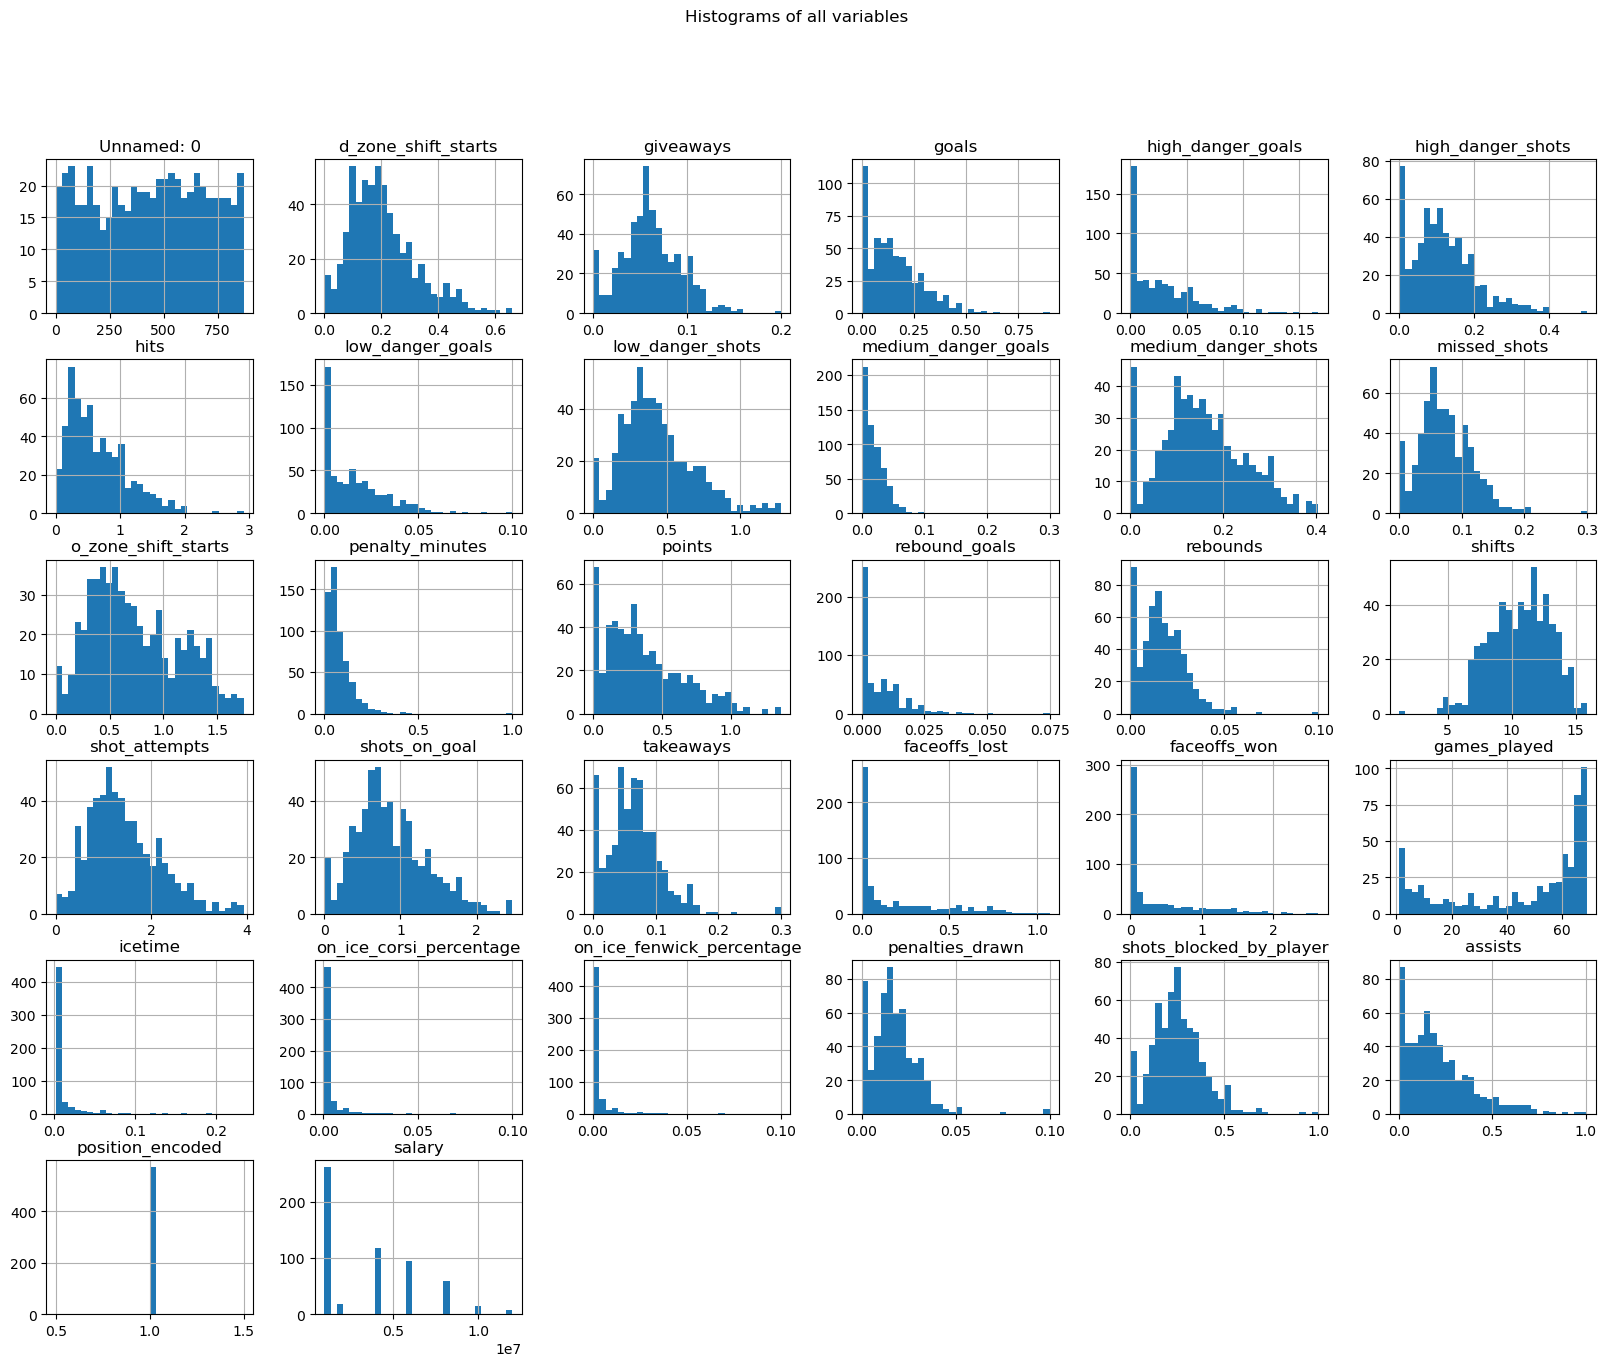

In [651]:
# Histogram for each variable
skaters_all.hist(bins=30, figsize=(20, 15))
plt.suptitle('Histograms of all variables')
plt.show()

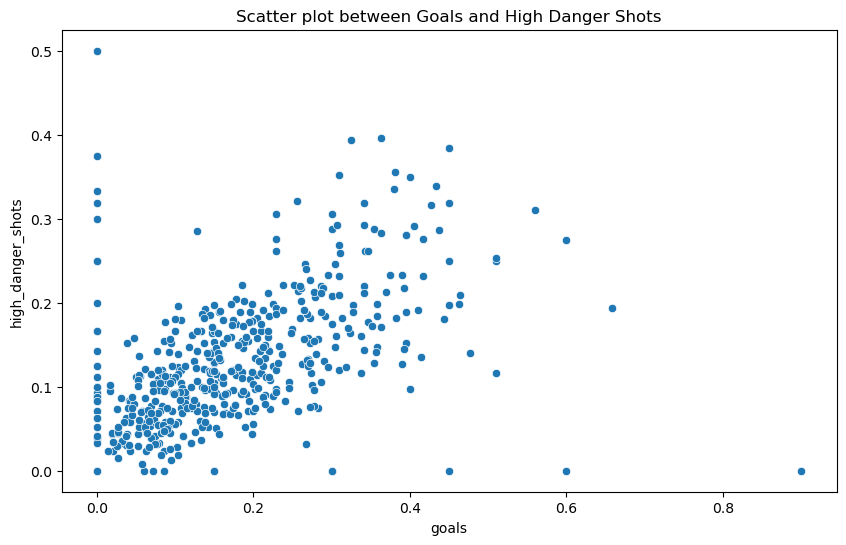

In [652]:
# Scatter plot between "goals" and "High Danger Shots"
plt.figure(figsize=(10, 6))
sns.scatterplot(x='goals', y='high_danger_shots', data=skaters_all)
plt.title('Scatter plot between Goals and High Danger Shots')
plt.show()

In [653]:
# Identify columns that you want to average (exclude 'games_played')
cols_to_average = skaters_all.columns.drop(['games_played', 'name', 'team', 'position_encoded', 'salary', 'icetime', 'position'])

# Divide each of those columns by the 'games_played' column row-wise
skaters_all[cols_to_average] = skaters_all[cols_to_average].div(skaters_all['games_played'], axis=0)

# Display the head of the DataFrame to verify the change
skaters_all.head()


,Unnamed: 0,name,team,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,position,shots_blocked_by_player,assists,position_encoded,salary
0,0.000000,A.J. Greer,Florida Panthers,0.001838,0.000757,0.001168,0.000216,0.001514,0.020004,0.000195,...,68,0.002341,0.000011,0.000011,0.000541,F,0.002379,0.002141,1,950000.0
2,0.095238,Aatu Raty,Vancouver Canucks,0.005669,0.000907,0.004082,0.000000,0.000000,0.060091,0.000680,...,21,0.007544,0.000111,0.000104,0.000454,F,0.004535,0.004082,1,950000.0
4,0.078431,Adam Edstrom,New York Rangers,0.004575,0.000730,0.001730,0.000192,0.002115,0.018070,0.000115,...,51,0.003031,0.000017,0.000017,0.000384,F,0.006536,0.001384,1,950000.0
5,0.074627,Adam Fantilli,Columbus Blue Jackets,0.001760,0.001693,0.004210,0.000668,0.001114,0.010359,0.000200,...,67,0.004424,0.000011,0.000011,0.000379,F,0.005458,0.004210,1,950000.0
7,0.107692,Adam Gaudette,Ottawa Senators,0.001302,0.000876,0.003408,0.000710,0.001657,0.006746,0.000213,...,65,0.002702,0.000013,0.000013,0.000047,F,0.003077,0.001491,1,4000000.0


In [654]:
skaters_all.columns.to_list()

['Unnamed: 0',
 'name',
 'team',
 'd_zone_shift_starts',
 'giveaways',
 'goals',
 'high_danger_goals',
 'high_danger_shots',
 'hits',
 'low_danger_goals',
 'low_danger_shots',
 'medium_danger_goals',
 'medium_danger_shots',
 'missed_shots',
 'o_zone_shift_starts',
 'penalty_minutes',
 'points',
 'rebound_goals',
 'rebounds',
 'shifts',
 'shot_attempts',
 'shots_on_goal',
 'takeaways',
 'faceoffs_lost',
 'faceoffs_won',
 'games_played',
 'icetime',
 'on_ice_corsi_percentage',
 'on_ice_fenwick_percentage',
 'penalties_drawn',
 'position',
 'shots_blocked_by_player',
 'assists',
 'position_encoded',
 'salary']

In [655]:
# Define weights for your features (make sure the keys match your DataFrame columns)
# For example, if you want to weight 'goals' at 0.7 and 'faceoffs' at 0.3:
feature_weights = {
    'd_zone_shift_starts': 0.1,
    'giveaways': 0.1,
    'goals': 0.9,
    'high_danger_goals': 0.5,
    'high_danger_shots': 0.5,
    'hits': 0.5,
    'low_danger_goals': 0.3,
    'low_danger_shots': 0.3,
    'medium_danger_goals':  0.3,
    'medium_danger_shots': 0.3,
    'missed_shots': 0.1,
    'o_zone_shift_starts': 0.3,
    'penalty_minutes': 0.2,
    'points': 0.9,
    'rebound_goals': 0.3,
    'rebounds': 0.1,
    'shifts': 0.6,
    'shot_attempts': 0.5,
    'shots_on_goal': 0.6,
    'takeaways': 0.3,
    'faceoffs_lost': 0.1,
    'faceoffs_won': 0.2,
    'icetime': 1,
    'on_ice_corsi_percentage': 0.1,
    'on_ice_fenwick_percentage': 0.1,
    'penalties_drawn': 0.1,
    'shots_blocked_by_player': 0.5,
    'assists': 0.9
    # add any other features and desired weights here
}

# Apply the weights: Multiply each feature column by its weight
for feature, weight in feature_weights.items():
    if feature in skaters_all.columns:
        skaters_all[feature] = skaters_all[feature] * weight

# Verify the changes
skaters_all.head()

,Unnamed: 0,name,team,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,position,shots_blocked_by_player,assists,position_encoded,salary
0,0.000000,A.J. Greer,Florida Panthers,0.000184,0.000076,0.001051,0.000108,0.000757,0.010002,0.000058,...,68,0.002341,0.000001,0.000001,0.000054,F,0.001189,0.001927,1,950000.0
2,0.095238,Aatu Raty,Vancouver Canucks,0.000567,0.000091,0.003673,0.000000,0.000000,0.030045,0.000204,...,21,0.007544,0.000011,0.000010,0.000045,F,0.002268,0.003673,1,950000.0
4,0.078431,Adam Edstrom,New York Rangers,0.000458,0.000073,0.001557,0.000096,0.001057,0.009035,0.000035,...,51,0.003031,0.000002,0.000002,0.000038,F,0.003268,0.001246,1,950000.0
5,0.074627,Adam Fantilli,Columbus Blue Jackets,0.000176,0.000169,0.003789,0.000334,0.000557,0.005179,0.000060,...,67,0.004424,0.000001,0.000001,0.000038,F,0.002729,0.003789,1,950000.0
7,0.107692,Adam Gaudette,Ottawa Senators,0.000130,0.000088,0.003067,0.000355,0.000828,0.003373,0.000064,...,65,0.002702,0.000001,0.000001,0.000005,F,0.001538,0.001342,1,4000000.0


In [656]:
skaters_all = skaters_all.drop(columns=['Unnamed: 0'])

In [674]:
# Check for NaN values in the DataFrame
nan_summary = skaters_all.isna().sum()

# Display columns with NaN values
print("Columns with NaN values:")
print(nan_summary[nan_summary > 0])

Columns with NaN values:
Series([], dtype: int64)


In [657]:
skaters_all.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/NHL_points_projection/files/master_copies/forward_final.csv')

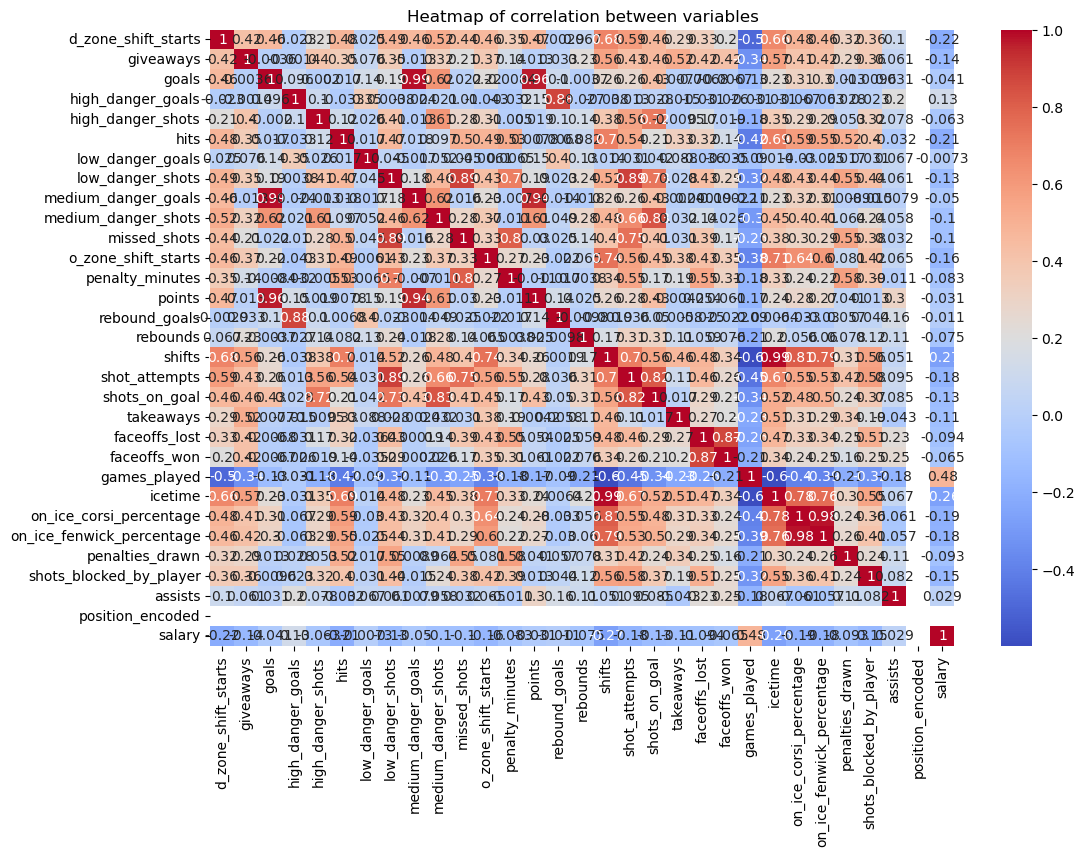

In [658]:
# Heatmap to show correlation between variables
numeric_df = skaters_all.drop(columns=['name', 'team', 'position'])


plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of correlation between variables')
plt.show()

In [659]:
# Select the features to use for the recommender engine
features = [
    'd_zone_shift_starts',
    'giveaways',
    'goals',
    'high_danger_goals',
    'high_danger_shots',
    'hits',
    'low_danger_goals',
    'low_danger_shots',
    'medium_danger_goals',
    'medium_danger_shots',
    'missed_shots',
    'o_zone_shift_starts',
    'penalty_minutes',
    'points',
    'rebound_goals',
    'rebounds',
    'shifts',
    'shot_attempts',
    'shots_on_goal',
    'takeaways',
    'faceoffs_lost',
    'faceoffs_won',
    'icetime',
    'on_ice_corsi_percentage',
    'on_ice_fenwick_percentage',
    'penalties_drawn',
    'shots_blocked_by_player',
    'assists',
]

In [660]:
# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(skaters_all[features])

<Axes: >

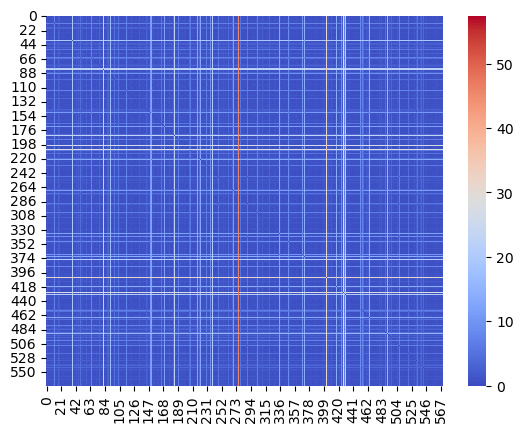

In [661]:
# Calculate euclidean distances
skater_dist = euclidean_distances(scaled_features)

sns.heatmap(skater_dist, cmap='coolwarm')

<Axes: >

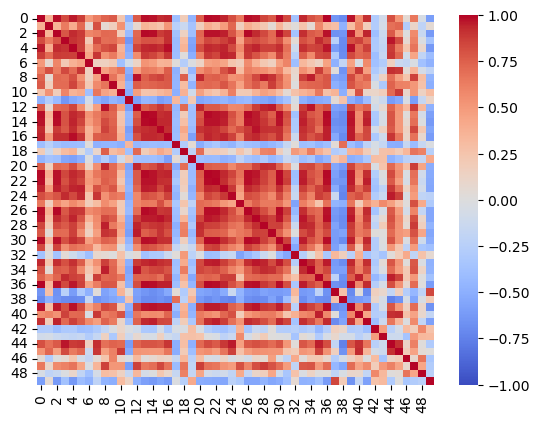

In [662]:
# Calculate cosine similarities
skater_sims = cosine_similarity(scaled_features)

sns.heatmap(skater_sims[:50, :50], cmap='coolwarm', vmin=-1, vmax=1)

In [663]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust the number of components as needed
pca_features = pca.fit_transform(scaled_features)

# Create a new DataFrame with the PCA features
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])
pca_df['name'] = skaters_all['name'].values
pca_df['team'] = skaters_all['team'].values
pca_df['position_encoded'] = skaters_all['position_encoded'].values
pca_df['salary'] = skaters_all['salary'].values



# Create a mapping dictionary for position_encoded
position_mapping = {0: 'D', 1: 'F'}  # Adjust the mapping as needed

# Apply the mapping to the position_encoded column
pca_df['position'] = pca_df['position_encoded'].map(position_mapping)

# Drop the position_encoded column
pca_df = pca_df.drop(columns=['position_encoded'])



In [664]:
# Function to find the 5 closest players
def find_closest_forwards(player_name, df, n=5):
    # Get the feature values for the target player
    target_player = df[df['name'] == player_name].drop(columns=['name', 'position', 'salary', 'team'])
    
    # Calculate the Euclidean distances between the target player and all other players
    distances = euclidean_distances(df.drop(columns=['name', 'position', 'salary', 'team']), target_player).flatten()
    
    # Get the indices of the 5 closest players
    closest_indices = np.argsort(distances)[1:n+1]  # Exclude the target player itself
    
    # Get the player names of the closest players
    closest_players = df.iloc[closest_indices][['name', 'position','team', 'salary']]
    
    return closest_players

In [665]:
# Example usage
target_player_name = 'John Tavares'  # Replace with the target player's name
closest_players = find_closest_forwards(target_player_name, pca_df)

# Display the closest players
print(f'Because you like {target_player_name}, you might also enjoy these similar players: {closest_players}')

Because you like John Tavares, you might also enjoy these similar players:                 name position                 team     salary
154     Dylan Larkin        F    Detroit Red Wings  8000000.0
155     Dylan Strome        F  Washington Capitals  6000000.0
195      J.T. Miller        F     New York Rangers  6000000.0
40   Anthony Cirelli        F  Tampa Bay Lightning  6000000.0
398    Nico Hischier        F    New Jersey Devils  8000000.0
